In [1]:
import desitarget 
from desitarget.targets import desi_mask, bgs_mask, mws_mask

from astropy.table import Table
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
import astropy.units as U

import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [2]:
N = Table.read('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/clustering/BGS_BRIGHT_N_clustering.dat.fits')
S = Table.read('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/clustering/BGS_BRIGHT_S_clustering.dat.fits')
N['APPLIM'] = 19.539993
S['APPLIM'] = 19.5

In [3]:
data = Table(np.hstack((N,S))) #BGS ANY in N, S combined
data['ZLIM_UPPER'] = 0.6

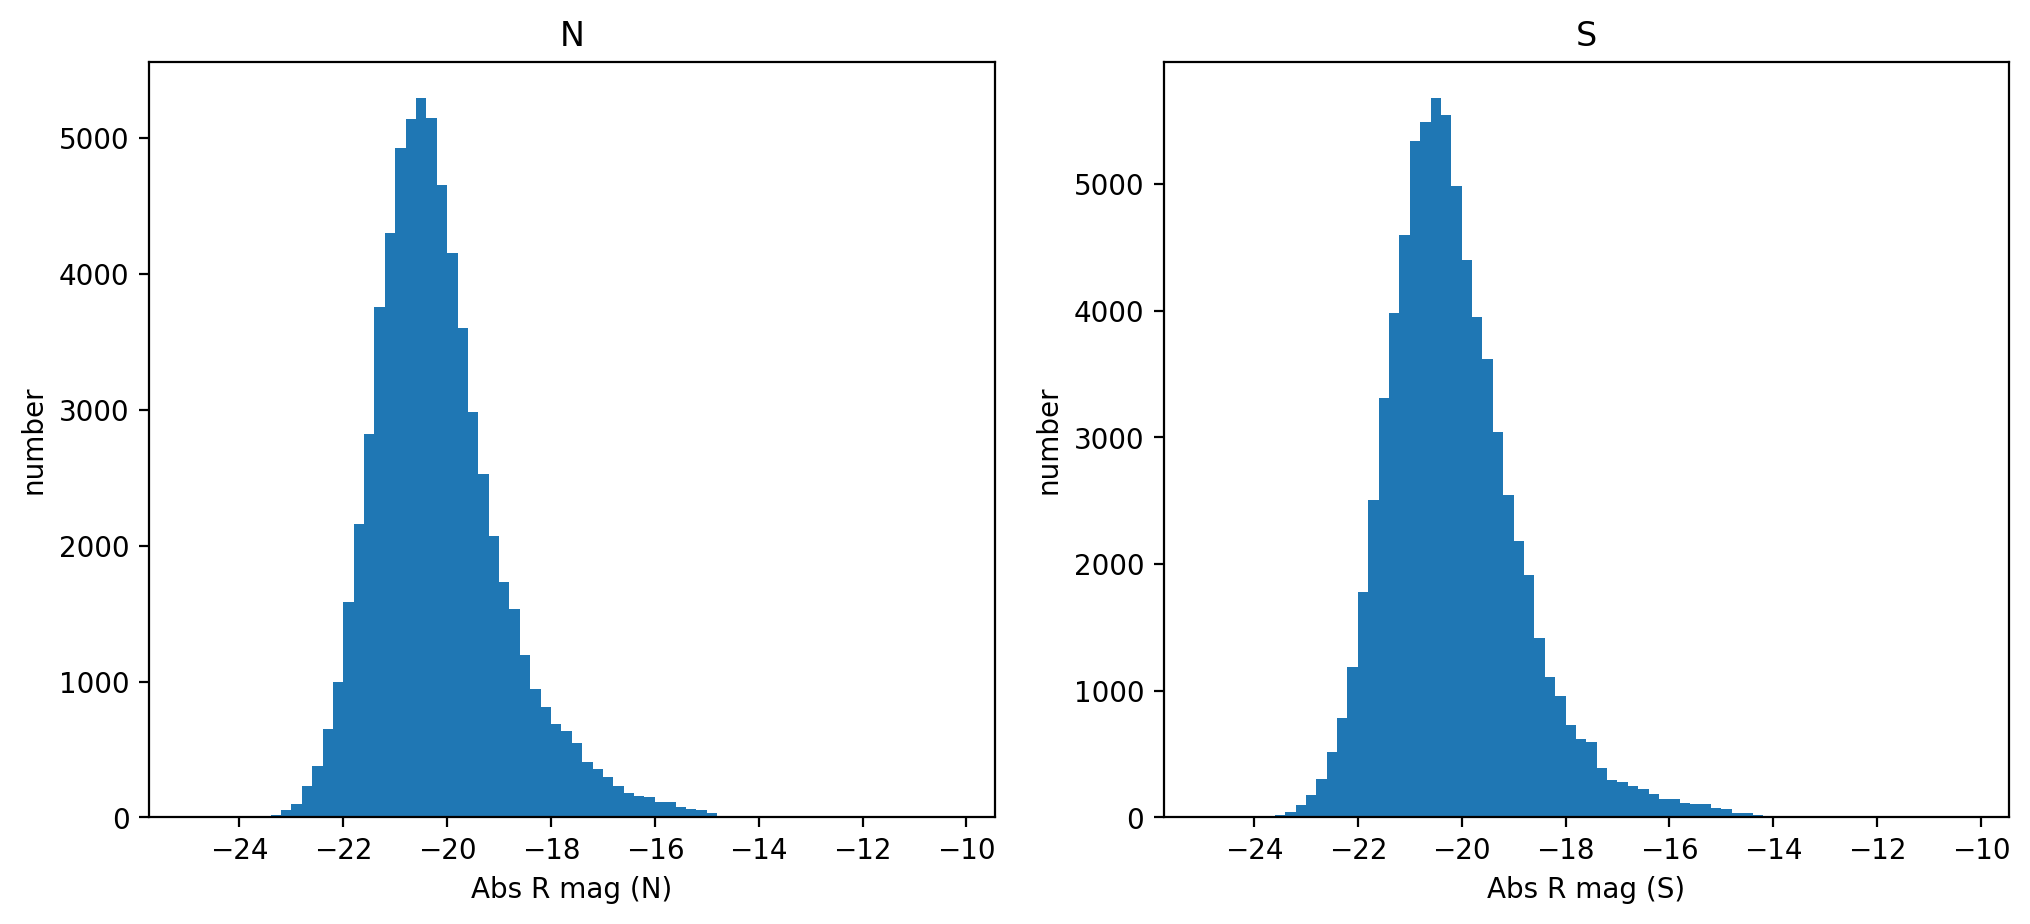

In [4]:
plt.figure(figsize=(12,5),dpi=200)
M_range = np.arange(-25,-10,0.2)
plt.subplot(121)
plt.title('N')
plt.hist(N['ABSMAG_R'], bins=M_range)
plt.xlabel('Abs R mag (N)')
plt.ylabel('number')

plt.subplot(122)
plt.title('S')
plt.hist(S['ABSMAG_R'], bins=M_range)
plt.xlabel('Abs R mag (S)')
plt.ylabel('number')

plt.savefig('../figures/week8-9/sv3_bright_abs_rmag_hist')

In [5]:
data['z_mag'] = 22.5 - 2.5*np.log10(data['flux_z_dered'])
data['w1_mag'] = 22.5 - 2.5*np.log10(data['flux_w1_dered'])
data['g_mag'] = 22.5 - 2.5*np.log10(data['flux_g_dered'])
data['r_mag'] = 22.5 - 2.5*np.log10(data['flux_r_dered'])

N['z_mag'] = 22.5 - 2.5*np.log10(N['flux_z_dered'])
N['w1_mag'] = 22.5 - 2.5*np.log10(N['flux_w1_dered'])
N['g_mag'] = 22.5 - 2.5*np.log10(N['flux_g_dered'])
N['r_mag'] = 22.5 - 2.5*np.log10(N['flux_r_dered'])

S['z_mag'] = 22.5 - 2.5*np.log10(S['flux_z_dered'])
S['w1_mag'] = 22.5 - 2.5*np.log10(S['flux_w1_dered'])
S['g_mag'] = 22.5 - 2.5*np.log10(S['flux_g_dered'])
S['r_mag'] = 22.5 - 2.5*np.log10(S['flux_r_dered'])


/tmp/ipykernel_125577/4066366636.py:2: RuntimeWarning: invalid value encountered in log10
  data['w1_mag'] = 22.5 - 2.5*np.log10(data['flux_w1_dered'])
/tmp/ipykernel_125577/4066366636.py:7: RuntimeWarning: invalid value encountered in log10
  N['w1_mag'] = 22.5 - 2.5*np.log10(N['flux_w1_dered'])
/tmp/ipykernel_125577/4066366636.py:12: RuntimeWarning: invalid value encountered in log10
  S['w1_mag'] = 22.5 - 2.5*np.log10(S['flux_w1_dered'])


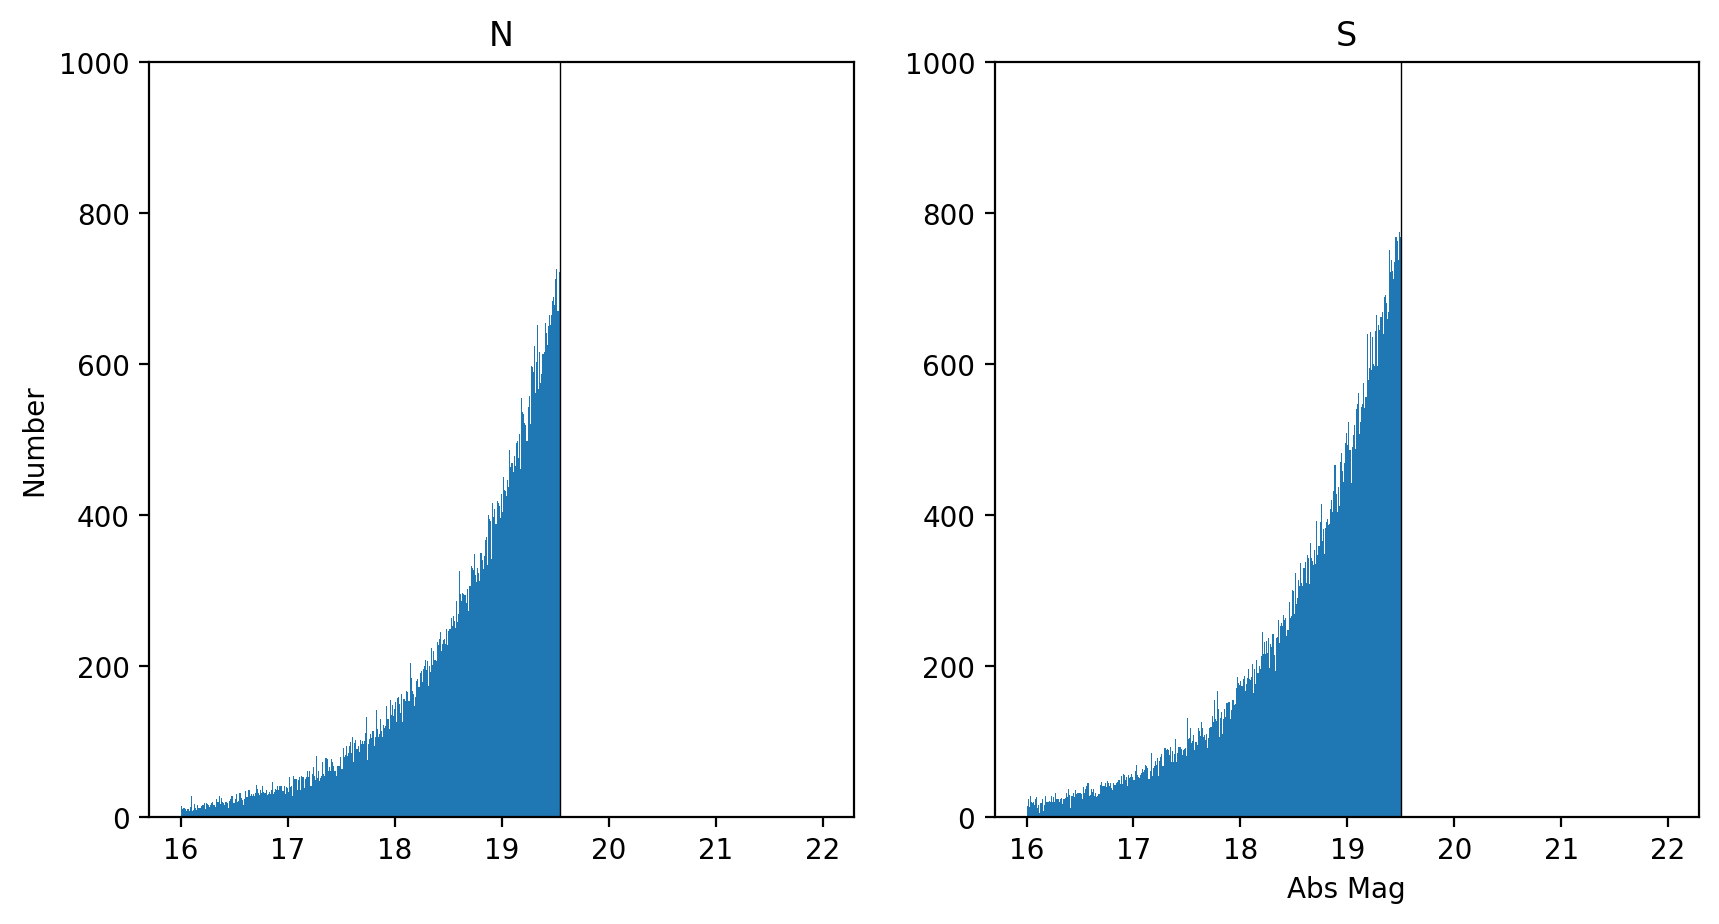

In [6]:
plt.figure(figsize=(10,5), dpi=200)

plt.subplot(121)
plt.title('N')
plt.hist(N['r_mag'], bins=np.arange(16,22,0.01))
plt.plot([19.539993,19.539993],[0,1000], lw=0.5, color='k')
plt.ylim(0,1000)
plt.ylabel('Number')

plt.subplot(122)
plt.title('S')
plt.hist(S['r_mag'], bins=np.arange(16,22,0.01))
plt.plot([19.5,19.5],[0,1000], lw=0.5, color='k')
plt.ylim(0,1000)
plt.xlabel('Abs Mag')


plt.show()

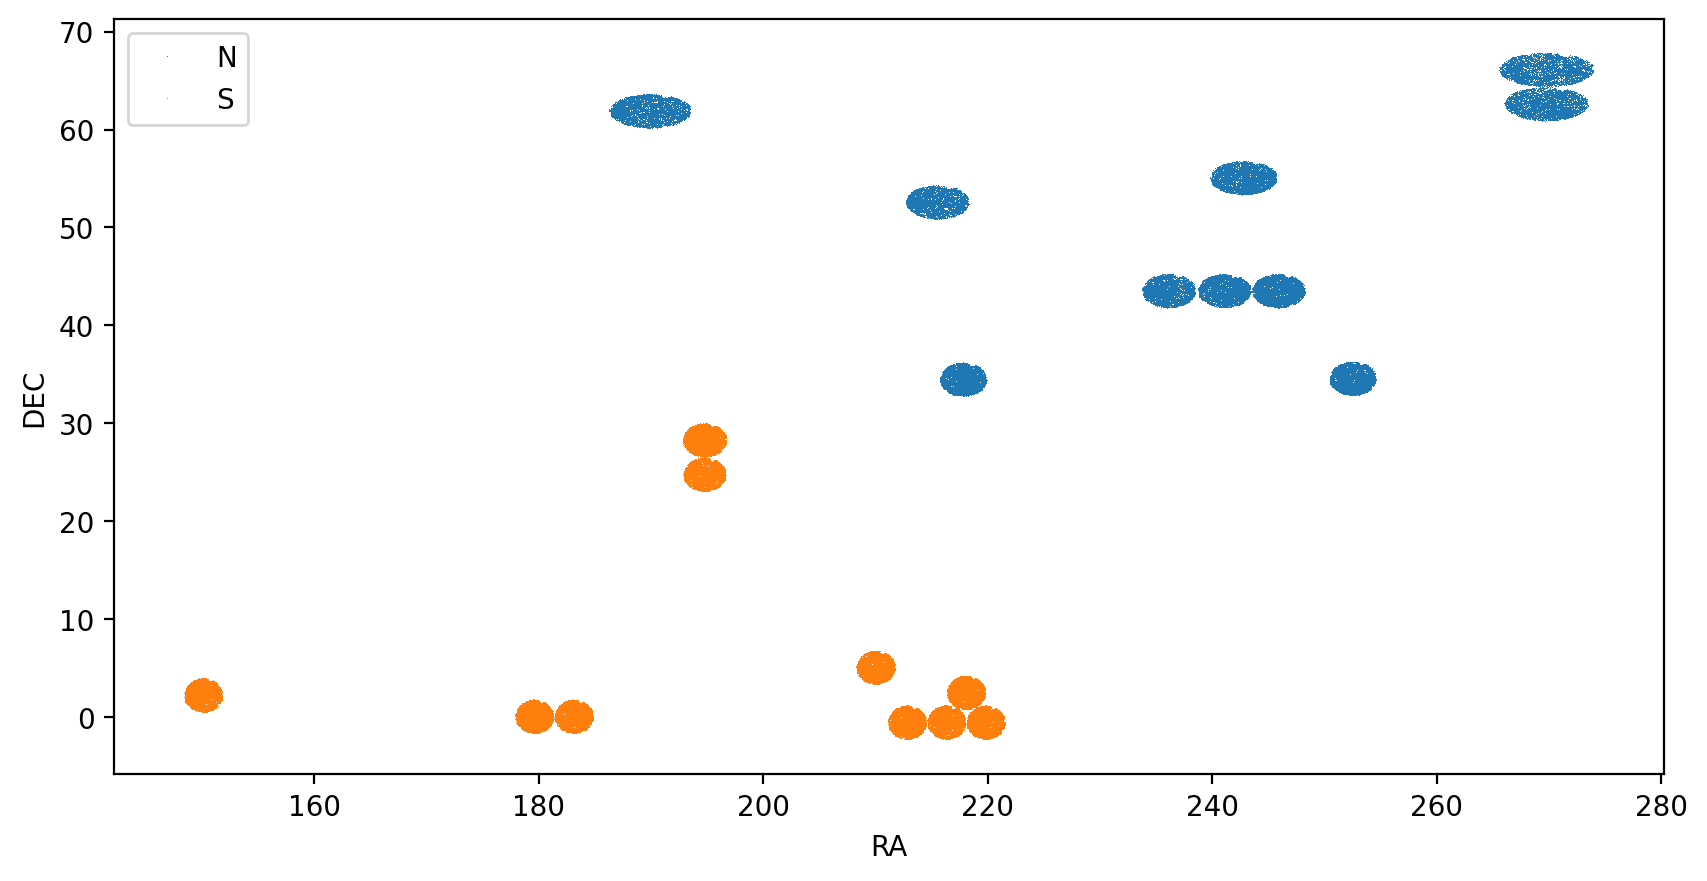

In [7]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(N['RA'], N['DEC'], lw=0, marker=',', label='N')
plt.plot(S['RA'], S['DEC'], lw=0, marker=',', label='S')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend()

plt.savefig('../figures/week8-9/sv3_bright_sky_coverage.png')

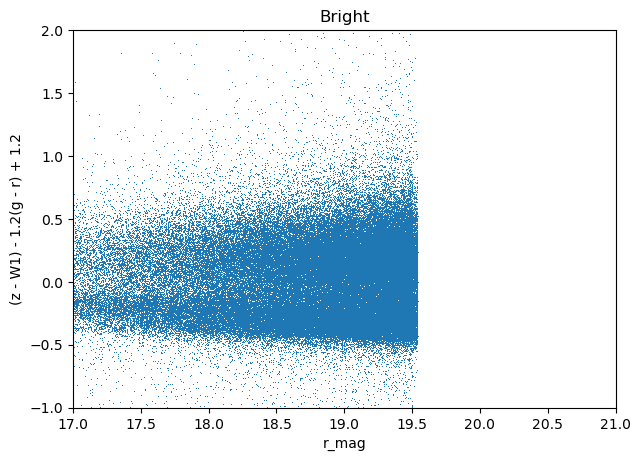

In [8]:
Y = (data['z_mag'] - data['w1_mag']) - 1.2*(data['g_mag'] - data['r_mag']) + 1.2
plt.figure(figsize=(7,5), dpi=100)
plt.title('Bright')
plt.plot(data['r_mag'], Y, lw=0, marker=',', color='tab:blue')
plt.plot(data['r_mag'], Y, lw=0, marker=',', color='tab:blue')
plt.ylim((-1,2))
plt.xlim((17,21))
plt.ylabel('(z - W1) - 1.2(g - r) + 1.2')
plt.xlabel('r_mag')
plt.savefig('../figures/week8-9/sv3_bright_Fig4.png')

#no faint

In [9]:
cosmo = FlatLambdaCDM(H0=100, Om0=0.3)
data['DL'] = cosmo.luminosity_distance(np.array(data['Z']))

In [10]:
data['ABSMAG_LIM'] = data['APPLIM'] - 5*np.log10(data['DL'])-25-data['KCORR_R0P1']-data['EQ_ALL_0P1']

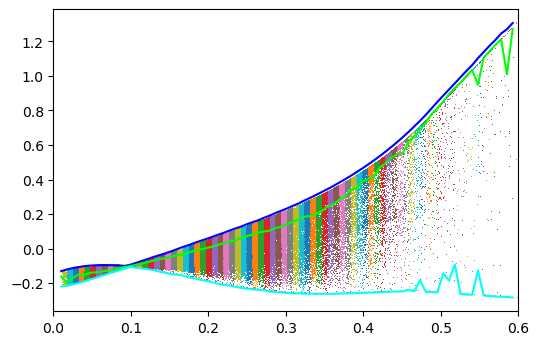

In [38]:
plt.figure(dpi=100)
def find_k(z_range, stat):
    if isinstance(z_range, np.ndarray):
        k = np.empty(len(z_range)-1)
        for i, z in enumerate(z_range):
            if i == len(z_range)-1:
                break
            z_close = np.where(np.logical_and(data['Z'] > (z), data['Z'] < (z_range[i+1])))[0]
            plt.plot(data['Z'][z_close], data['KCORR_R0P1'][z_close], lw=0, marker=',')
            if stat == 'med':
                k[i] = np.median(data['KCORR_R0P1'][z_close])
            elif stat == 'max':
                k[i] = np.amax(data['KCORR_R0P1'][z_close])
            elif stat == 'min':
                k[i] = np.amin(data['KCORR_R0P1'][z_close])
        return k


z_range = np.linspace(0.01,0.6,80)  
M_range = np.arange(-23,-16,0.01)
k_med = find_k(z_range, 'med') 
k_max = find_k(z_range, 'max')
k_min = find_k(z_range, 'min')
plt.plot(z_range[0:-1], k_max, color='blue')
plt.plot(z_range[0:-1], k_med, color='lime')
plt.plot(z_range[0:-1], k_min, color='aqua')

plt.xlim(0,0.6)
plt.show()

In [12]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [13]:
z1 = find_nearest(data['Z'], 0.1)
z2 = find_nearest(data['Z'], 0.5)
e_slope = (data['EQ_ALL_0P1'][z2] - data['EQ_ALL_0P1'][z1])/(data['Z'][z2] - data['Z'][z1])
print(data['Z'][z2], data['EQ_ALL_0P1'][z2])
print(data['Z'][z1], data['EQ_ALL_0P1'][z1])
print(e_slope)

e_intercept = data['EQ_ALL_0P1'][z2] - e_slope*data['Z'][z2]
print(e_intercept)
#y = mx+c

0.5000411802639463 -0.48503994485602786
0.10000013207827435 -0.09700012811592612
-0.9699999999999999
-5.551115123125783e-17


In [14]:
dl_range = cosmo.luminosity_distance(z_range[0:-1]).to_value()
e_z = e_slope*z_range[0:-1] + e_intercept
faintlim_range_N_max = 19.539993 - 5*np.log10(dl_range) - 25 - k_max - e_z
faintlim_range_S_max = 19.5  - 5*np.log10(dl_range) - 25 - k_max - e_z

faintlim_range_N_min = 19.539993 - 5*np.log10(dl_range) - 25 - k_min - e_z
faintlim_range_S_min = 19.5  - 5*np.log10(dl_range) - 25 - k_min - e_z

faintlim_range_N_med = 19.539993 - 5*np.log10(dl_range) - 25 - k_med - e_z
faintlim_range_S_med = 19.5  - 5*np.log10(dl_range) - 25 - k_med - e_z

brightlim_range_max = 15 - 5*np.log10(dl_range) - 25 - k_max - e_z
brightlim_range_min = 15 - 5*np.log10(dl_range) - 25 - k_min - e_z
brightlim_range_med = 15 - 5*np.log10(dl_range) - 25 - k_med - e_z

In [33]:
def absmag_lim(lim0, lim1, cat):
    return np.where(np.logical_and(cat['ABSMAG_R'] < lim0, cat['ABSMAG_R'] > lim1))

def find_zmax(M):
    z_array = []
    for m in M:
        i = find_nearest(faintlim_range_S_min, m) #ignore faintlim differences between S and N (use 19.5)
        z_array.append(z_range[i])
    return z_array

def redshift_lim_from_k(lim, cat):
    N_i = np.where(cat['APPLIM'] == 19.539993)
    S_i = np.where(cat['APPLIM'] == 19.5)
    cat['ZLIM_UPPER'][S_i] = z_range[find_nearest(faintlim_range_S_max,lim)]
    cat['ZLIM_UPPER'][N_i] = z_range[find_nearest(faintlim_range_N_max,lim)]

    upper_limed = np.where(cat['Z'] < np.minimum(cat['ZLIM_UPPER'],0.6))
    z_lim_lower = z_range[find_nearest(brightlim_range_min,lim)]
    return np.intersect1d(upper_limed, np.where(cat['Z'] > z_lim_lower))

      

print(redshift_lim_from_k(-20, data))

data['ZMAX'] = find_zmax(data['ABSMAG_R'])

[     0      2      5 ... 143849 143851 143852]


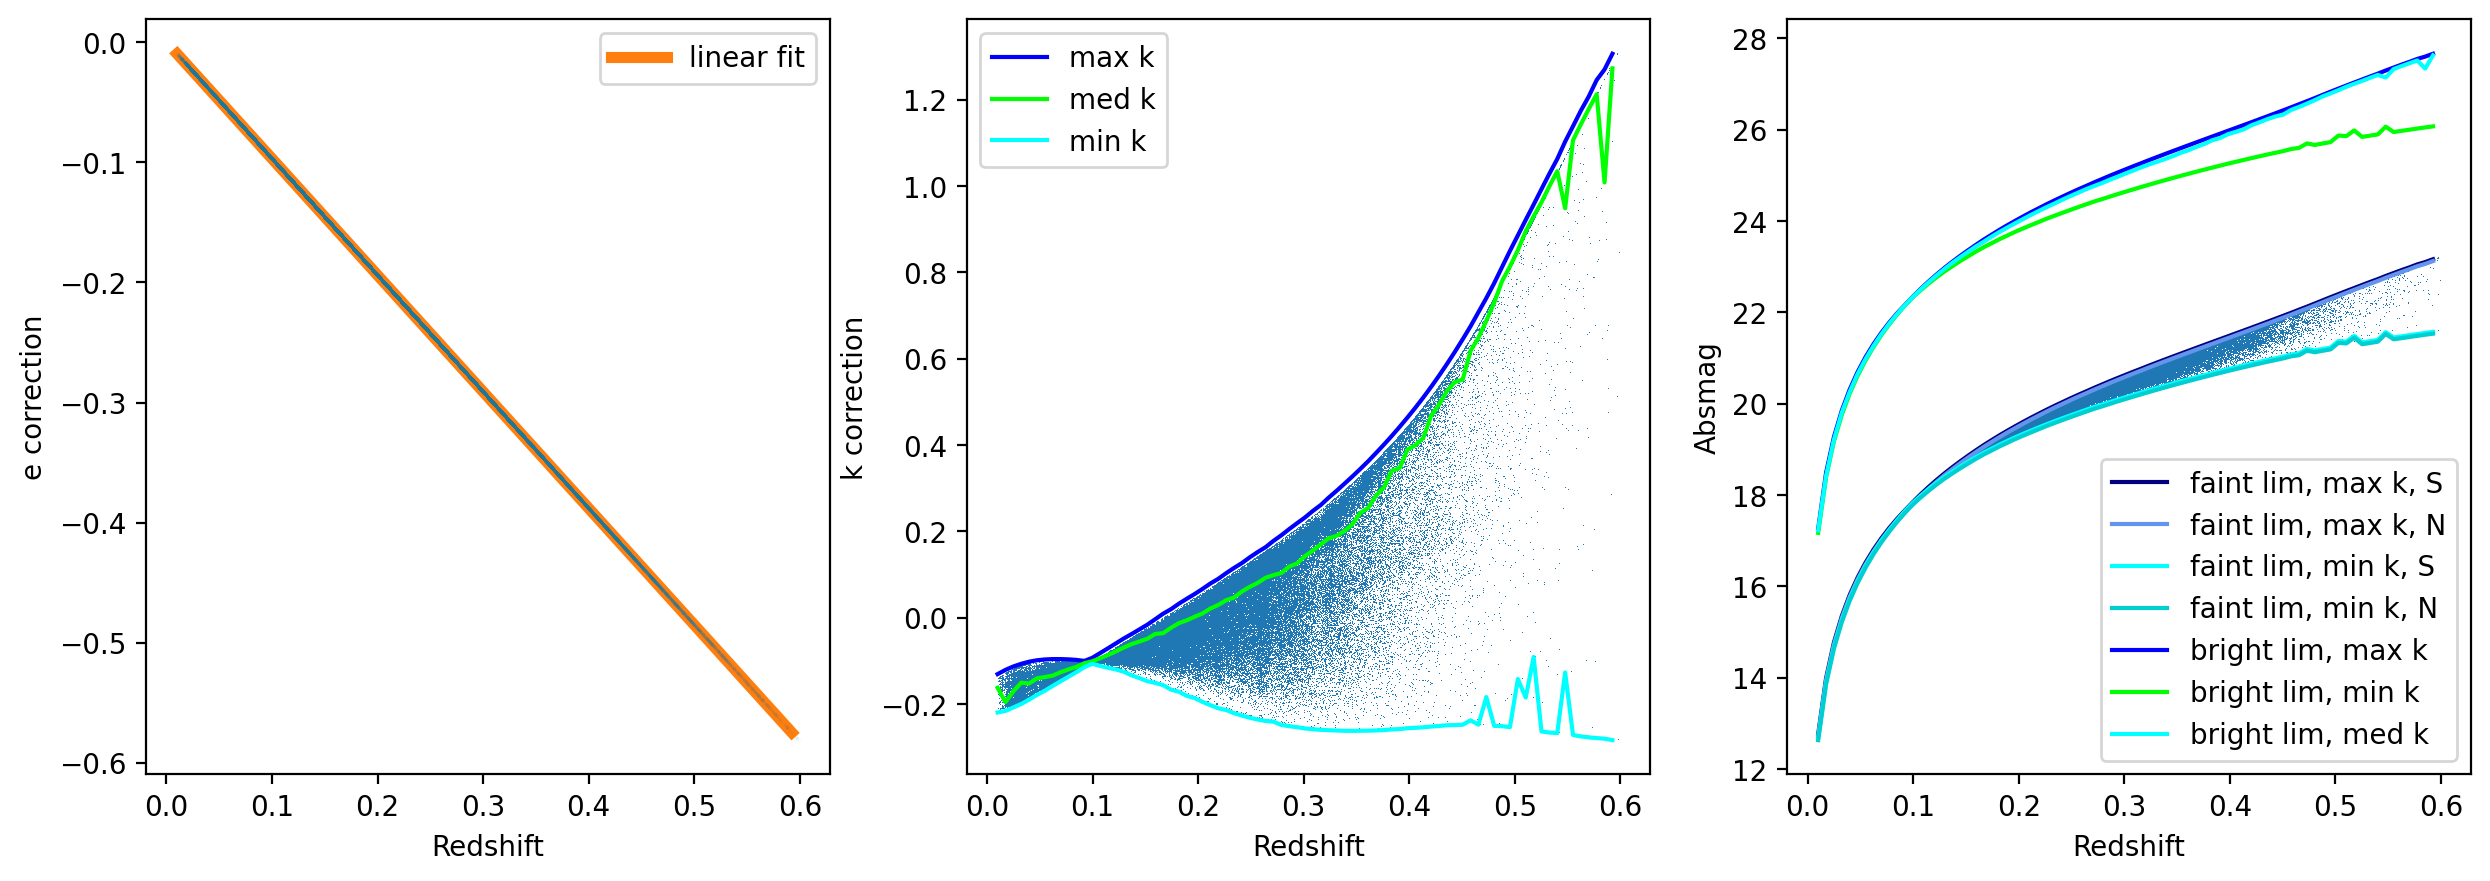

In [26]:
plt.figure(figsize=(15,5), dpi=200)

plt.subplot(131)
plt.plot(z_range[0:-1], e_z, label='linear fit', color='tab:orange', lw=4)
plt.plot(data['Z'], data['EQ_ALL_0P1'], lw=0, marker='o', color='tab:blue', markersize=0.01)
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('e correction')

plt.subplot(132)
plt.plot(data['Z'], data['KCORR_R0P1'], lw=0, marker=',')
plt.plot(z_range[0:-1], k_max, color='blue', label='max k')
plt.plot(z_range[0:-1], k_med, color='lime', label='med k')
plt.plot(z_range[0:-1], k_min, color='aqua', label='min k')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('k correction')

plt.subplot(133)
plt.plot(data['Z'], -data['ABSMAG_LIM'], lw=0, marker=',')
plt.plot(z_range[0:-1], -faintlim_range_S_max, color='navy', label='faint lim, max k, S')
plt.plot(z_range[0:-1], -faintlim_range_N_max, color='cornflowerblue', label='faint lim, max k, N')
#plt.plot(z_range[0:-1], -faintlim_range_S_med, color='lime', label='med k, S')
#plt.plot(z_range[0:-1], -faintlim_range_N_med, color='palegreen', label='med k, N')
plt.plot(z_range[0:-1], -faintlim_range_S_min, color='aqua', label='faint lim, min k, S')
plt.plot(z_range[0:-1], -faintlim_range_N_min, color='darkturquoise', label='faint lim, min k, N')
plt.plot(z_range[0:-1], -brightlim_range_max, color='blue', label='bright lim, max k')
plt.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
plt.plot(z_range[0:-1], -brightlim_range_med, color='aqua', label='bright lim, med k')

plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Absmag')
plt.savefig('../figures/week8-9/sv3_bright_corrections_and_absmag.png')


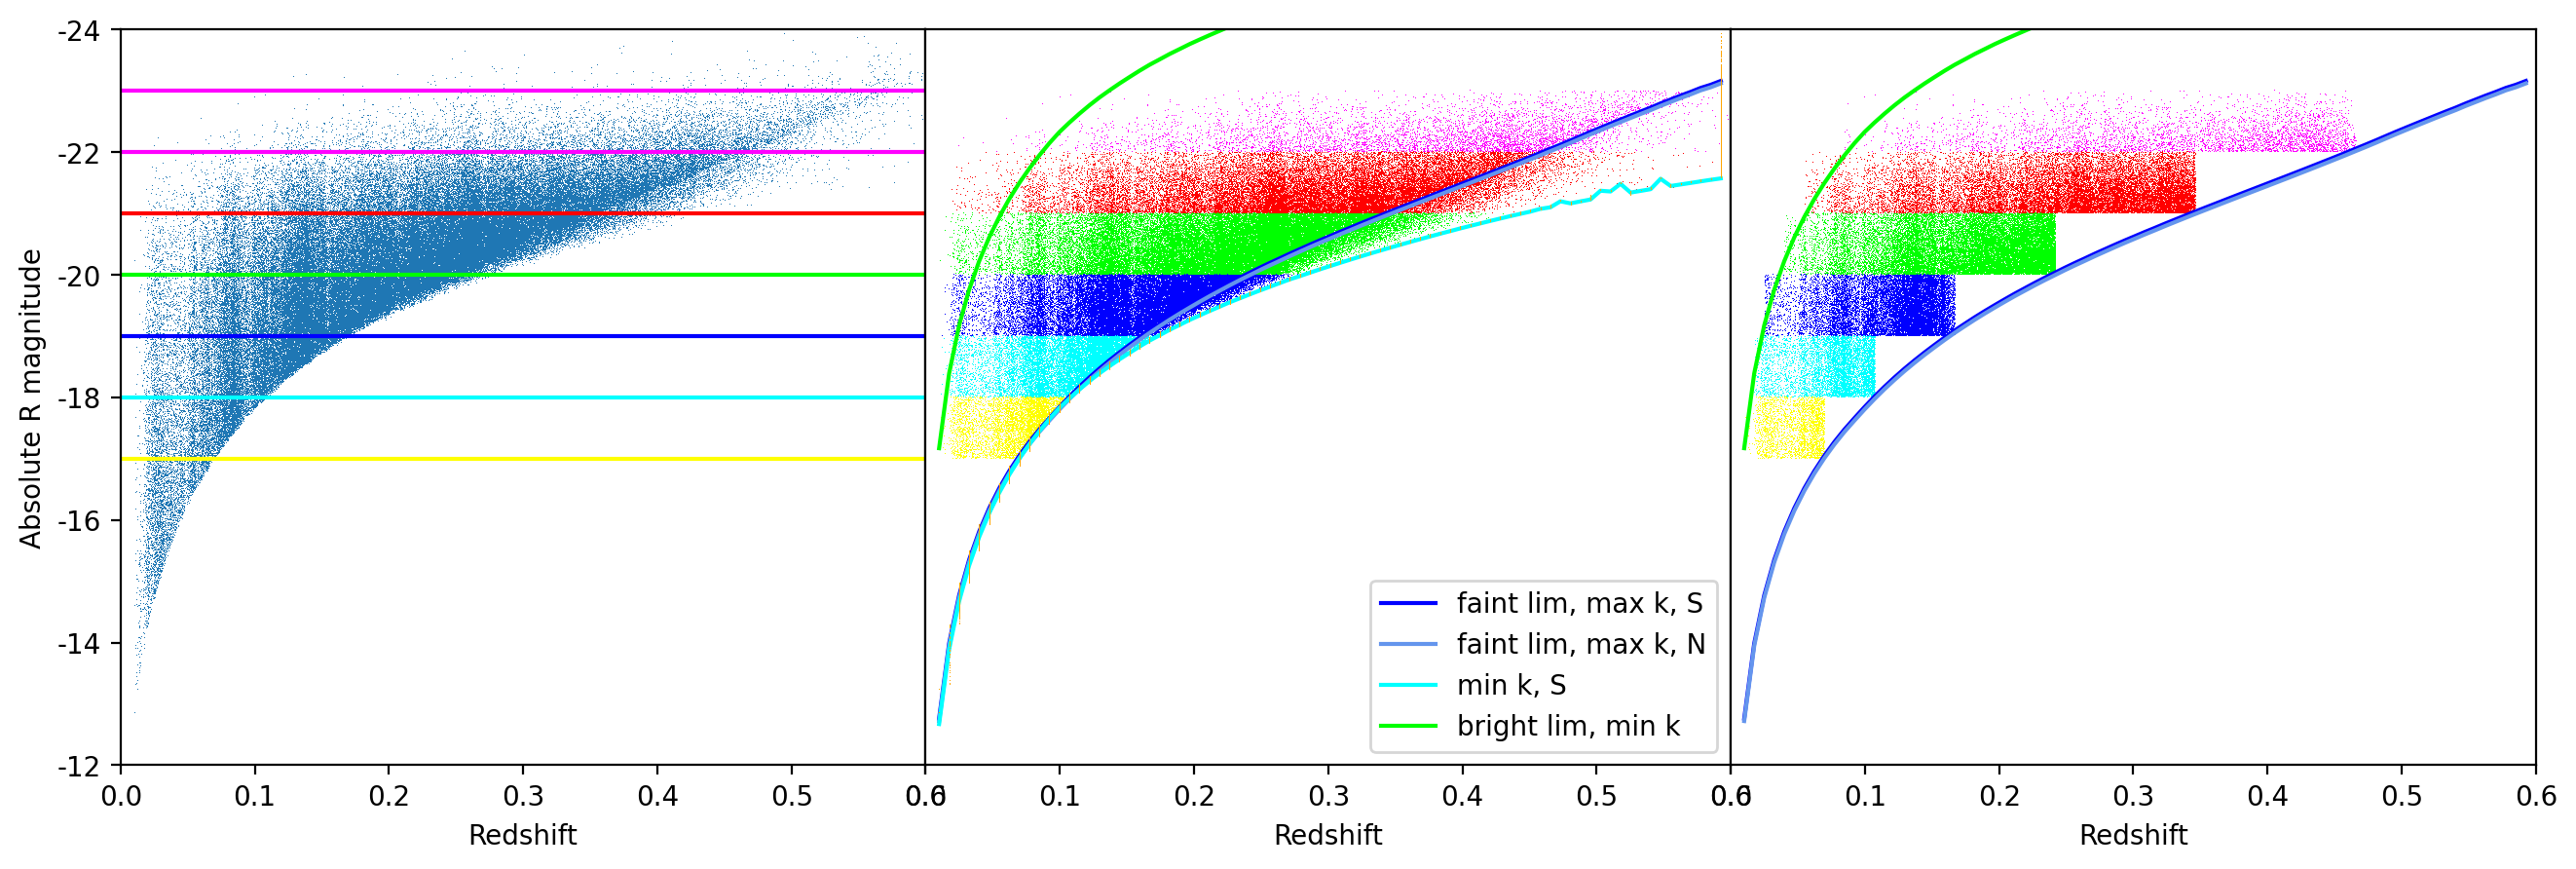

In [36]:
plt.figure(figsize=(16,5), dpi=200)
ax1 = plt.subplot(131)
ax1.plot(data['Z'], -data['ABSMAG_R'], lw=0, marker=',')
ax1.plot([0,0.6],[17,17], color='yellow')
ax1.plot([0,0.6],[18,18], color='cyan')
ax1.plot([0,0.6],[19,19], color='blue')
ax1.plot([0,0.6],[20,20], color='lime')
ax1.plot([0,0.6],[21,21], color='red')
ax1.plot([0,0.6],[22,22], color='magenta')
ax1.plot([0,0.6],[23,23], color='magenta')
plt.ylim(12,24)
plt.xlim(0,0.6)
plt.yticks([12,14,16,18,20,22,24],['-12','-14','-16','-18','-20','-22','-24'])
plt.xlabel('Redshift')
plt.ylabel('Absolute R magnitude')

ax2 = plt.subplot(132)
ax2.plot(data['Z'][absmag_lim(-17,-18, data)], -data['ABSMAG_R'][absmag_lim(-17,-18, data)], lw=0, marker=',', color='yellow')
ax2.plot(data['Z'][absmag_lim(-18,-19, data)], -data['ABSMAG_R'][absmag_lim(-18,-19, data)], lw=0, marker=',', color='cyan')
ax2.plot(data['Z'][absmag_lim(-19,-20, data)], -data['ABSMAG_R'][absmag_lim(-19,-20, data)], lw=0, marker=',', color='blue')
ax2.plot(data['Z'][absmag_lim(-20,-21, data)], -data['ABSMAG_R'][absmag_lim(-20,-21, data)], lw=0, marker=',', color='lime')
ax2.plot(data['Z'][absmag_lim(-21,-22, data)], -data['ABSMAG_R'][absmag_lim(-21,-22, data)], lw=0, marker=',', color='red')
ax2.plot(data['Z'][absmag_lim(-22,-23, data)], -data['ABSMAG_R'][absmag_lim(-22,-23, data)], lw=0, marker=',', color='magenta')
#ax2.plot(zmax_range, -M_range, color='tab:blue', lw=1, label='my estimate')
ax2.plot(z_range[0:-1], -faintlim_range_S_max, color='blue', label='faint lim, max k, S')
ax2.plot(z_range[0:-1], -faintlim_range_N_max, color='cornflowerblue', label='faint lim, max k, N')
#plt.plot(z_range[0:-1], -faintlim_range_S_med, color='lime', label='med k, S')

plt.plot(z_range[0:-1], -faintlim_range_S_min, color='aqua', label='min k, S')
#plt.plot(z_range[0:-1], -brightlim_range_max, color='blue', label='bright lim, max k')
ax2.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
#plt.plot(z_range[0:-1], -brightlim_range_med, color='aqua', label='bright lim, med k')

ax2.plot(data['ZMAX'], -data['ABSMAG_R'], lw=0, marker=',', color='orange')


plt.legend()
plt.yticks([])
plt.ylim(12,24)
plt.xlim(0,0.6)
plt.xlabel('Redshift')

ax3 = plt.subplot(133)
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-17,-18, data), redshift_lim_from_k(-17, data))], -data['ABSMAG_R'][np.intersect1d(absmag_lim(-17,-18, data), redshift_lim_from_k(-17, data))], lw=0, marker=',', color='yellow')
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-18,-19, data), redshift_lim_from_k(-18, data))], -data['ABSMAG_R'][np.intersect1d(absmag_lim(-18,-19, data), redshift_lim_from_k(-18, data))], lw=0, marker=',', color='cyan')
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-19,-20, data), redshift_lim_from_k(-19, data))], -data['ABSMAG_R'][np.intersect1d(absmag_lim(-19,-20, data), redshift_lim_from_k(-19, data))], lw=0, marker=',', color='blue')
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-20,-21, data), redshift_lim_from_k(-20, data))], -data['ABSMAG_R'][np.intersect1d(absmag_lim(-20,-21, data), redshift_lim_from_k(-20, data))], lw=0, marker=',', color='lime')
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-21,-22, data), redshift_lim_from_k(-21, data))], -data['ABSMAG_R'][np.intersect1d(absmag_lim(-21,-22, data), redshift_lim_from_k(-21, data))], lw=0, marker=',', color='red')
ax3.plot(data['Z'][np.intersect1d(absmag_lim(-22,-23, data), redshift_lim_from_k(-22, data))], -data['ABSMAG_R'][np.intersect1d(absmag_lim(-22,-23, data), redshift_lim_from_k(-22, data))], lw=0, marker=',', color='magenta')
ax3.plot(z_range[0:-1], -faintlim_range_S_max, color='blue', label='faint lim, max k, S')
ax3.plot(z_range[0:-1], -faintlim_range_N_max, color='cornflowerblue', label='faint lim, max k, N')
ax3.plot(z_range[0:-1], -brightlim_range_min, color='lime', label='bright lim, min k')
plt.yticks([])
plt.ylim(12,24)
plt.xlim(0,0.6)

plt.xlabel('Redshift')
plt.subplots_adjust(wspace=0)
plt.savefig('../figures/week8-9/sv3_bright_mag_v_redshift.png')


[21335 21336 21337 ... 61339 61340 61341] [     0      1      2 ... 143850 143851 143852]
[21335 21336 21337 ... 61339 61340 61341]


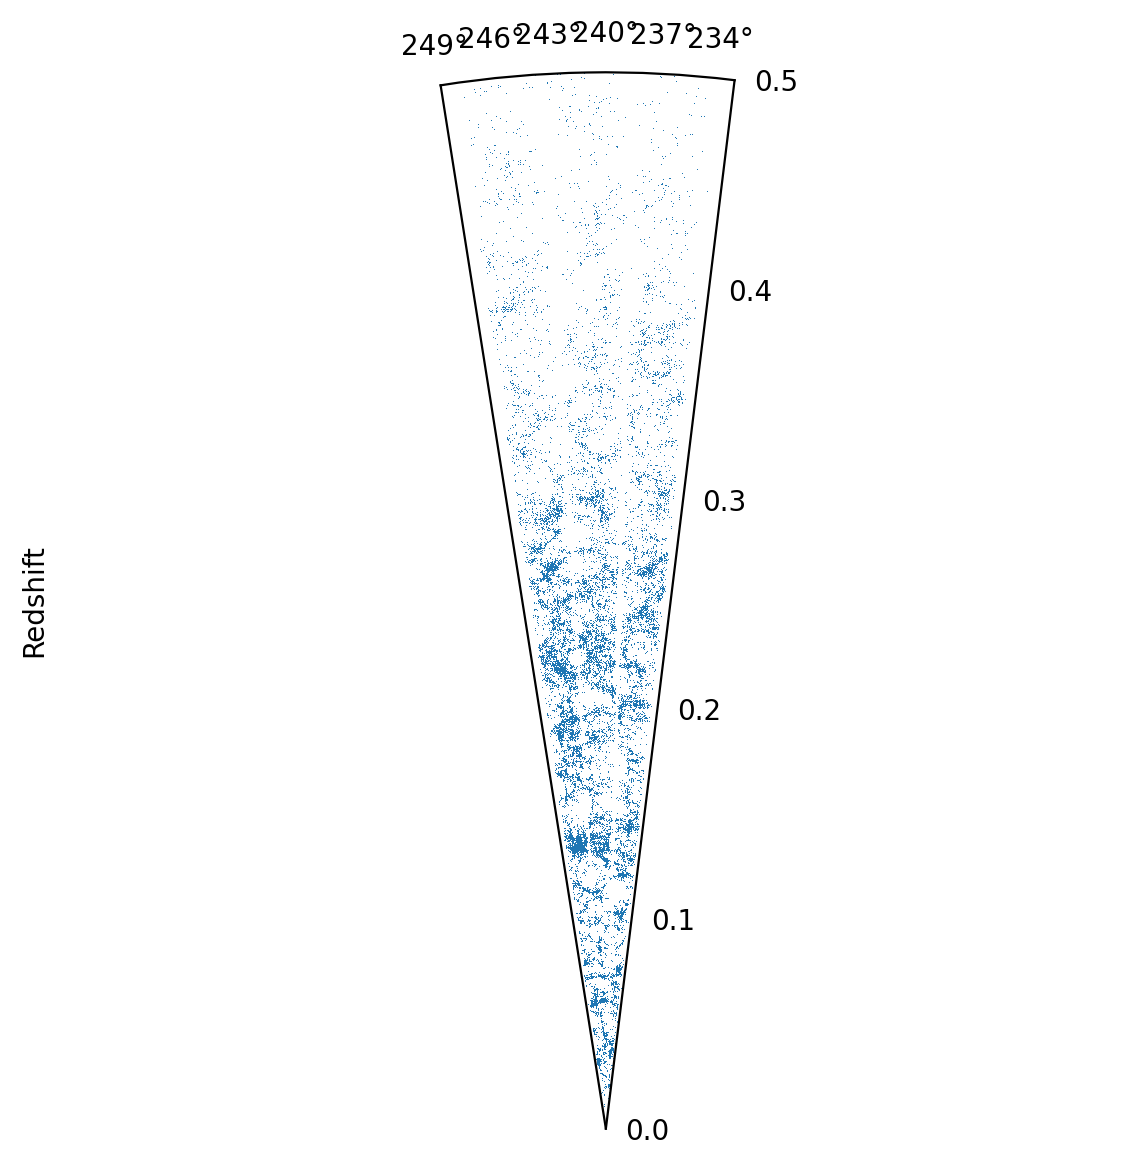

In [18]:
dec_slice = np.where(np.logical_and(data['DEC'] >= 40, data['DEC'] <= 50))[0]
redshift_cut = np.where(data['Z'] <= 0.5)[0]
print(dec_slice, redshift_cut)

cone_cut = np.intersect1d(dec_slice, redshift_cut)
print(cone_cut)

RA_rad = np.deg2rad(data['RA'])

fig, ax = plt.subplots(figsize=(7,7),subplot_kw={'projection': 'polar'}, dpi=200)
plt.grid(False)
ax.plot(RA_rad[cone_cut],data['Z'][cone_cut], lw=0, marker=',', color='tab:blue')
ax.set_theta_offset(np.deg2rad(210))
plt.ylim(0,0.5)
plt.xlim(np.deg2rad(233),np.deg2rad(249))
plt.ylabel('Redshift')
plt.savefig('../figures/week8-9/sv3_bright_cone_plot.png')

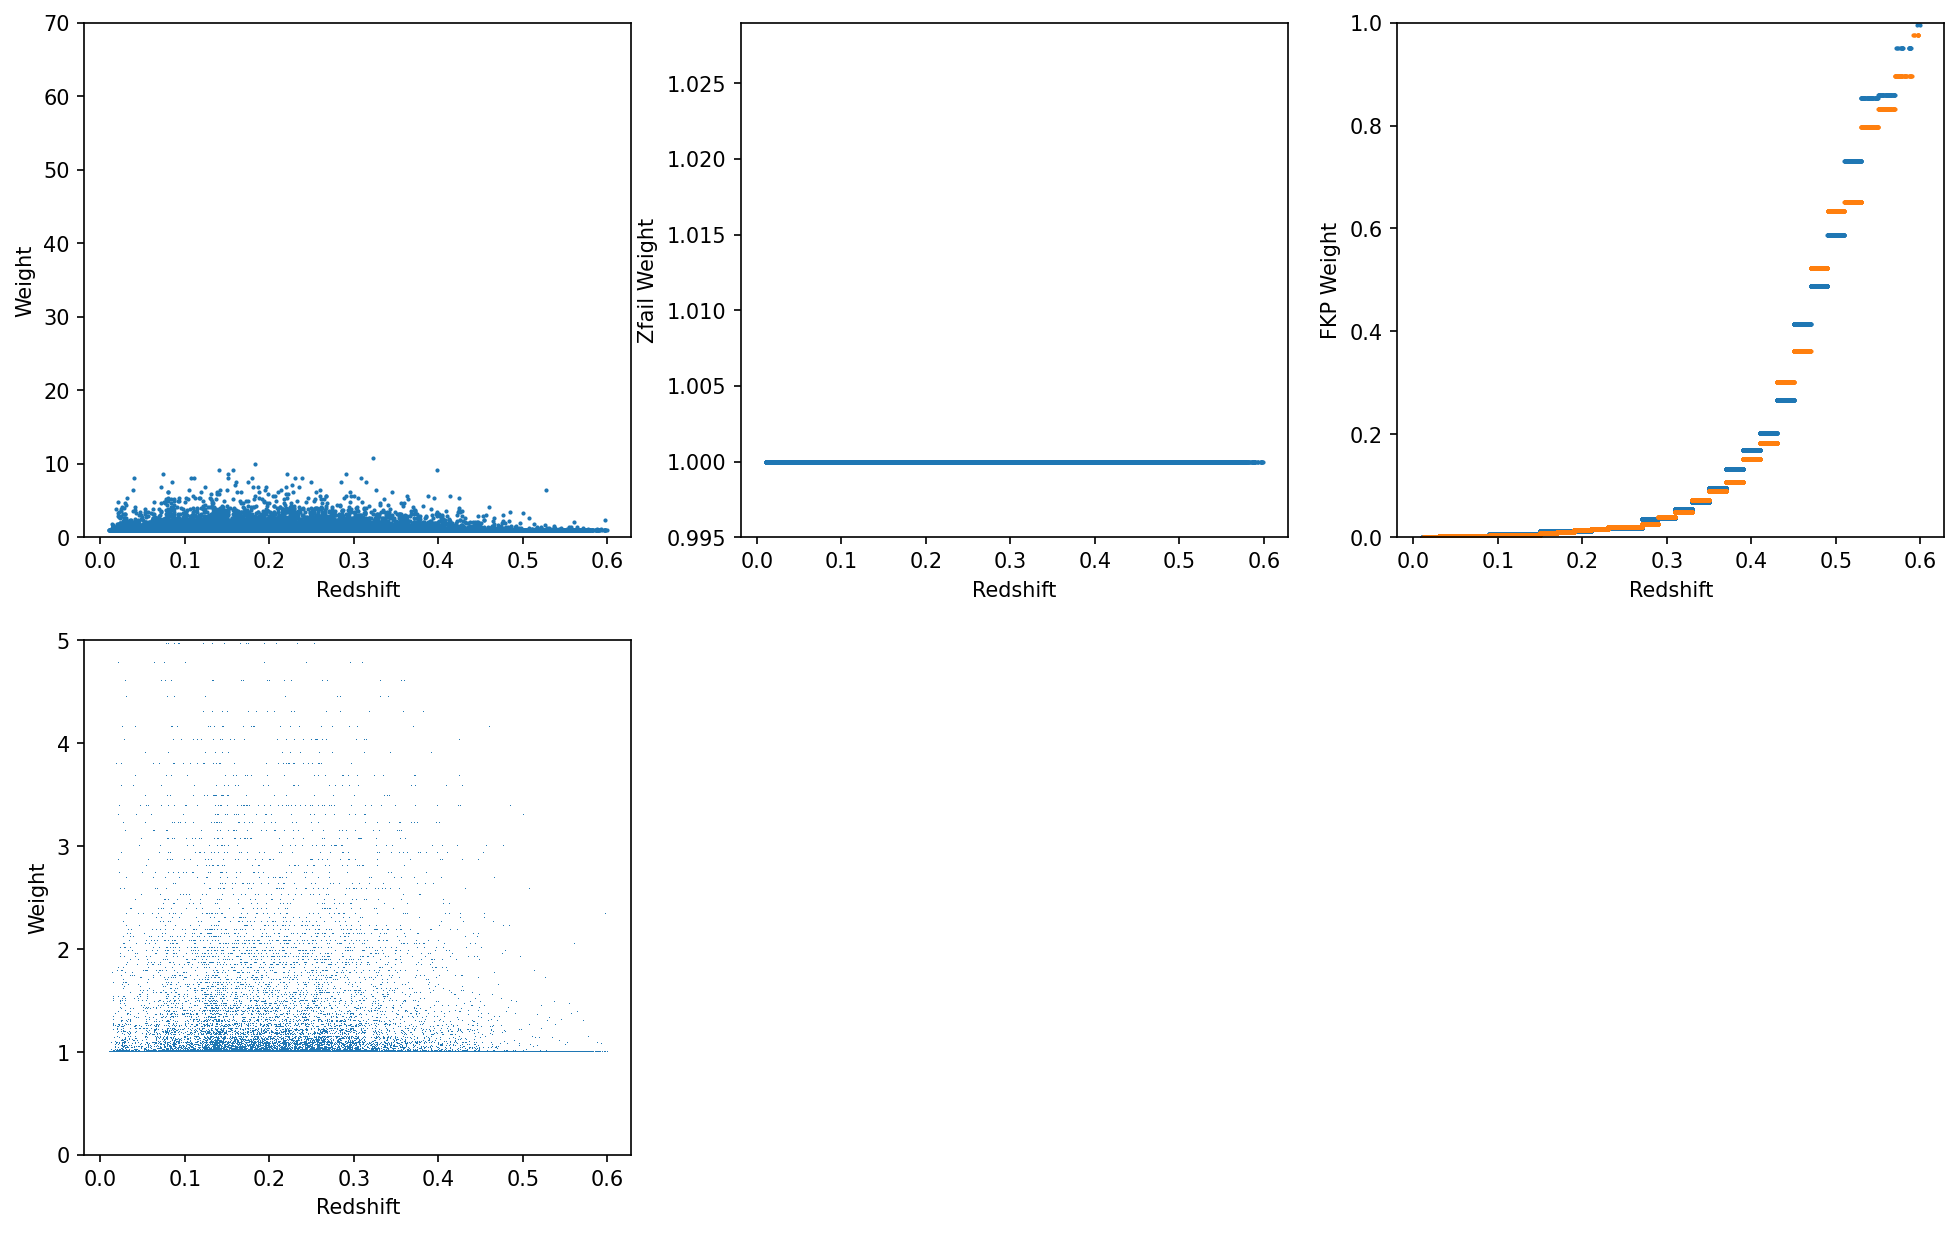

In [20]:
plt.figure(figsize=(16,10),dpi=150)
ax1 = plt.subplot(231)
ax1.plot(data['Z'], data['WEIGHT'], lw=0, marker='o', markersize=1)
plt.xlabel('Redshift')
plt.ylabel('Weight')
plt.ylim(0,70)

ax4 = plt.subplot(234)
ax4.plot(data['Z'], data['WEIGHT'], lw=0, marker=',')
plt.xlabel('Redshift')
plt.ylabel('Weight')
plt.ylim(0,5)

ax2 = plt.subplot(232)
ax2.plot(data['Z'], data['WEIGHT_ZFAIL'], lw=0, marker='o', markersize=1)
plt.xlabel('Redshift')
plt.ylabel('Zfail Weight')
plt.ylim(0.995,1.029)

ax3 = plt.subplot(233)
ax3.plot(N['Z'], N['WEIGHT_FKP'], lw=0, marker='o', markersize=1)
ax3.plot(S['Z'], S['WEIGHT_FKP'], lw=0, marker='o', markersize=1)
plt.xlabel('Redshift')
plt.ylabel('FKP Weight')
plt.ylim(0,1)

plt.savefig('../figures/week8-9/sv3_bright_weights.png')

#https://desi.lbl.gov/trac/wiki/ClusteringWG/LSScat/SV3/current_version
#WEIGHT = 129/(128*PROB_OBS + 1)
#There is one object which has zero probobs

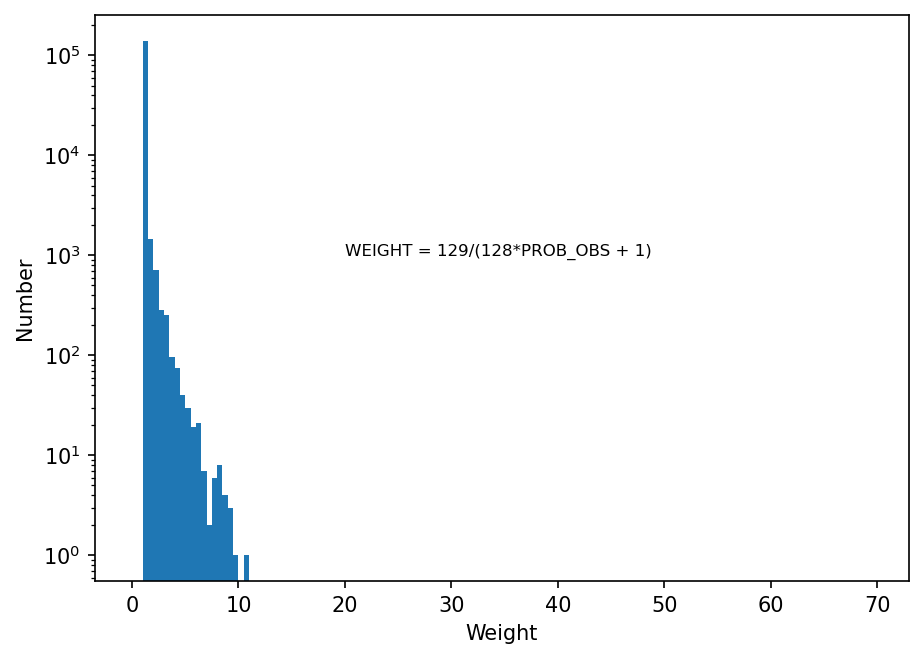

In [22]:
fig, ax = plt.subplots(figsize=(7,5), dpi=150)
ax.hist(data['WEIGHT'], np.arange(0,70,0.5))
ax.set_yscale('log')
plt.xlabel('Weight')
plt.ylabel('Number')
plt.text(20,1000,'WEIGHT = 129/(128*PROB_OBS + 1)', size=8)
plt.savefig('../figures/week8-9/sv3_bright_weight_hist.png')

In [23]:
def phi(M, phi_star=8.32*10**(-3), M_star=-20.3, alpha=-0.23): #luminosity function
    return np.log(10)*phi_star*10**(0.4*(alpha+1)*(-M+M_star))*np.exp(-10**(0.4*(-M+M_star)))/2.5

In [43]:
! ls /global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats

BGS_ANY_N_nz.txt	ELG_HIPnotqso_S_nz.txt	LRG_main_N_nz.txt
BGS_ANY_S_nz.txt	ELG_HIP_S_nz.txt	LRG_main_S_nz.txt
BGS_BRIGHT_N_nz.txt	ELG_N_nz.txt		LRG_N_nz.txt
BGS_BRIGHT_S_nz.txt	ELGnotqso_N_nz.txt	LRG_S_nz.txt
clustering		ELGnotqso_S_nz.txt	QSO_N_nz.txt
ELG_HIP_N_nz.txt	ELG_S_nz.txt		QSO_S_nz.txt
ELG_HIPnotqso_N_nz.txt	full


In [44]:
with open('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/BGS_BRIGHT_N_nz.txt') as file:
    print('N')
    print(file.read())

with open('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/BGS_BRIGHT_S_nz.txt') as file:
    print('S')
    print(file.read())

N
#area is 86.2884square degrees
#zmid zlow zhigh n(z) Nbin Vol_bin
0.02 0.01 0.03 0.13010677988769906 781.1812945386218 6004.1551655716485
0.04 0.03 0.05 0.08453159877481627 1878.8883629037439 22227.05343488078
0.06 0.05 0.06999999999999999 0.0504667514780847 2447.893617456757 48505.076030498225
0.07999999999999999 0.06999999999999999 0.09 0.04785387196770399 4029.775568397744 84210.02110586561
0.1 0.09 0.11 0.020758901725607407 2672.156884917317 128723.42285917004
0.12 0.11 0.13 0.020644622490123412 3745.7301364113882 181438.53868983954
0.14 0.13 0.15000000000000002 0.024799977701634248 5995.695020658713 241762.11336930408
0.16000000000000003 0.15000000000000002 0.17 0.01194305741581003 3691.7900898400612 309115.99612281256
0.18 0.17 0.19 0.012707690463455164 4866.263760284227 382938.48707431543
0.2 0.19 0.21000000000000002 0.011258318032178506 5209.060867048283 462685.5319027011
0.22000000000000003 0.21000000000000002 0.23 0.009219810701767882 5050.9055317359625 547831.8042655106
0.

In [46]:
A = 86.2884+87.204
sky_area = 4*np.pi*np.rad2deg(1)**2
fsky_hdr = A/sky_area
print(fsky_hdr)

0.004205574454426402


In [48]:
zmax_clipped = np.clip(data['ZMAX'], a_min=None, a_max=0.3)
data['VMAX'] = fsky_hdr*cosmo.comoving_volume(zmax_clipped)
data['VMAX']

437838.21098887105
10295656.035231248
6120930.231777487
10295656.035231248
10295656.035231248
437838.21098887105
7791950.749374129
10295656.035231248
10295656.035231248
10295656.035231248
10295656.035231248


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


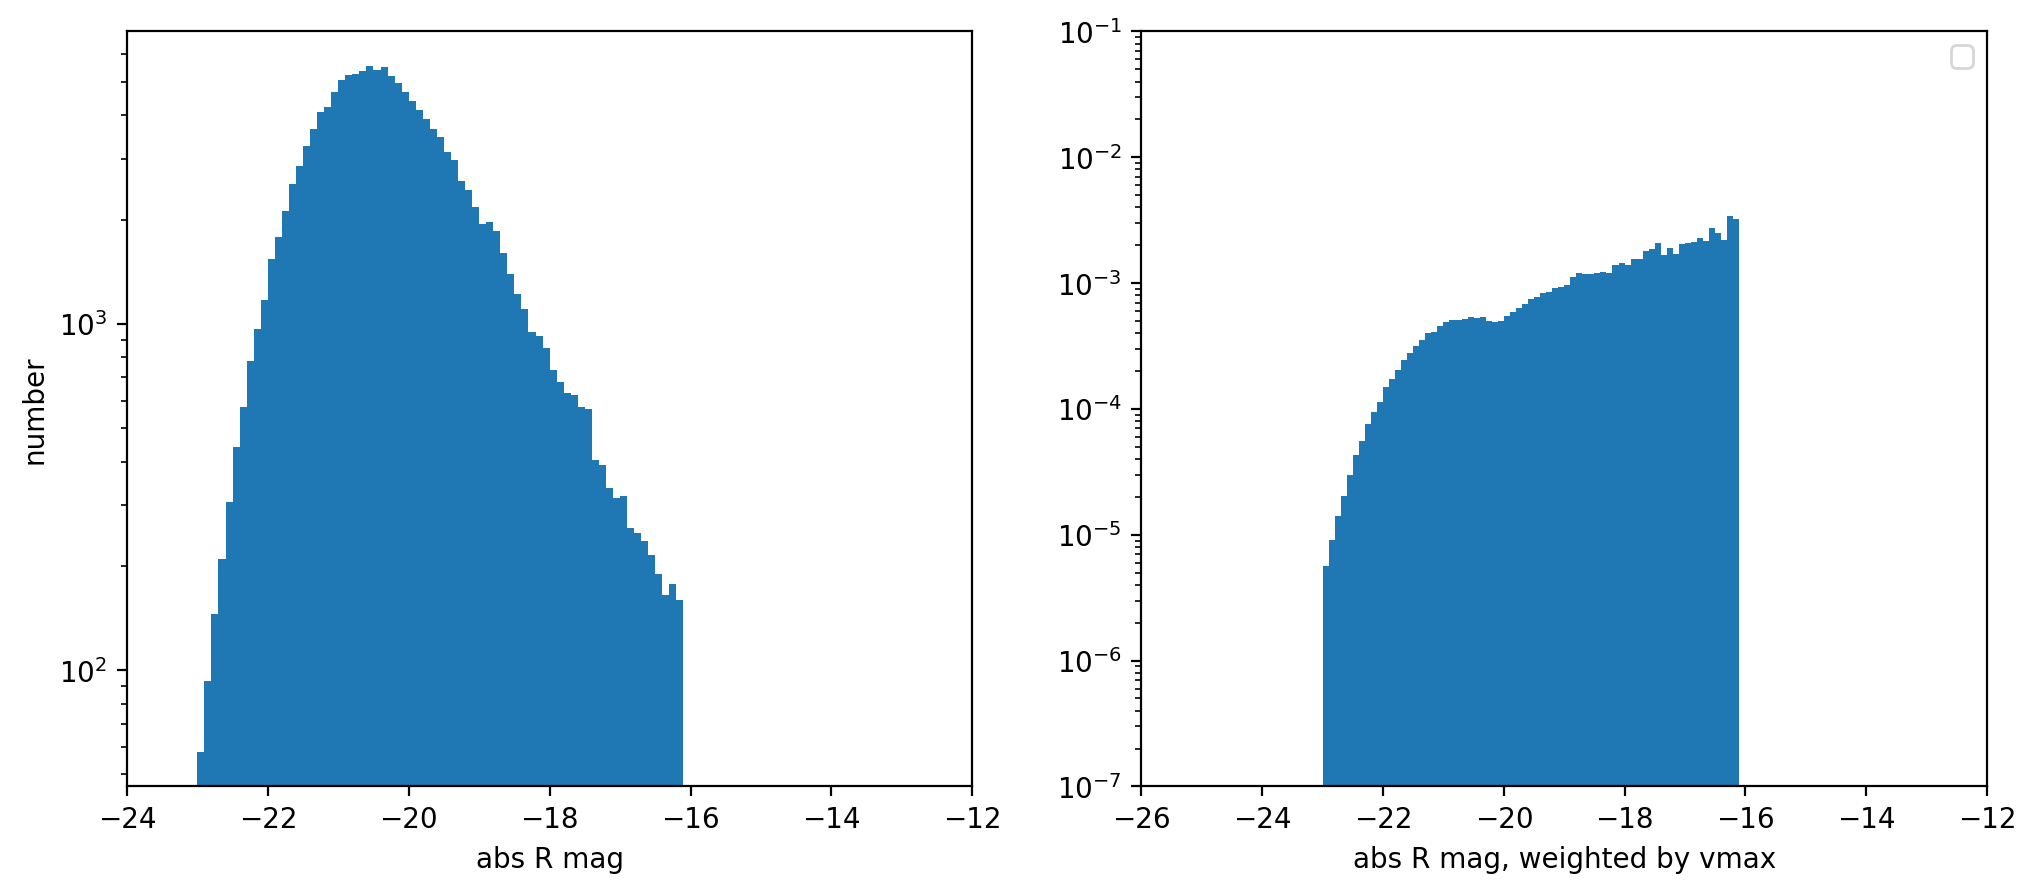

In [56]:
phi_star_est = 0.00000000003
M_star_est = -22 #-21.5#-19.7+5*np.log10(5) for b-band
alpha_est = -1.25 #-1.07
M_range = np.arange(-23,-16,0.1)

plt.figure(figsize=(12,5),dpi=200)
ax1 = plt.subplot(121)
ax1.hist(data['ABSMAG_R'][redshift_cut], bins=M_range)
ax1.set_yscale('log')
plt.xlabel('abs R mag')
plt.ylabel('number')
plt.xlim(-24,-12)
ax2 = plt.subplot(122)
ax2.set_yscale('log')
ax2.hist(data['ABSMAG_R'][redshift_cut], bins=M_range, weights=1/data['VMAX'][redshift_cut])
#ax2.plot(M_range, phi(M_range, phi_star=0.000000000015, M_star=-20, alpha=-1.02))
"""                                                          
ax2.plot(M_range, phi(M_range, phi_star=0.000000001, M_star=M_star_est, alpha=alpha_est), label='fastphot estimate (phi adjusted)', ls='--')
ax2.plot(M_range, phi(M_range, phi_star=0.0000000013, M_star=-21.3, alpha=alpha_est), label='my estimate', ls='--', color='tab:cyan')
ax2.plot(M_range, phi(M_range, phi_star=0.0000000015, M_star=-20.7, alpha=-1.25), label='McNaught-Roberts+ 2014 (phi adjusted)', color='tab:olive')
ax2.plot(M_range, phi(M_range, phi_star=10**(-2.03), M_star=-20.7, alpha=-1.25), color='tab:olive')"""
plt.xlabel('abs R mag, weighted by vmax')
plt.ylim(10**-7,10**-1)
plt.xlim(-26,-12)
plt.legend()

### 